In [1]:
import pandas as pd
from pandas_datareader import data, wb
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats, integrate
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
import bs4 as bs
import requests
import yfinance as yf
import seaborn as sns
from collections import OrderedDict, defaultdict

import cvxpy as cp

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 07 11:04:39 AM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) May 07 11:04:39 AM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


In [2]:
import numpy as np

## Get Universe - Current S&P 500 stocks that exhisted in 2002

In [17]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime(2000,1,1)
end = datetime(2022,1,1)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 946702800, endDate = 1641013200
- BF.B: No data found for this date range, symbol may be delisted


In [18]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
SP_Close = data['Adj Close']
SP_Close=SP_Close.dropna(axis=0, how='all')
SP_Close=SP_Close.dropna(axis=1)

## Testing Initial Portfolio without Bayes

In [19]:
five_year_data=SP_Close[:1265] #5 years of data
five_year_data.tail()

,A,AAPL,ABC,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,...,WMT,WRB,WST,WY,XEL,XOM,XRAY,YUM,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-07,13.948149,1.057321,11.317925,14.29,15.050692,29.384233,23.419273,14.685474,22.294916,34.282318,...,37.189430,6.975884,10.584787,13.893994,9.064569,28.189127,24.471766,12.140297,53.099998,49.812931
2005-01-10,13.880587,1.052894,11.317925,14.42,15.196448,29.404230,23.327047,14.806498,22.310621,34.222351,...,37.003429,7.007395,10.730641,13.951581,9.189453,28.296692,25.020784,12.142911,53.840000,49.843582
2005-01-11,13.641053,0.985713,11.345290,14.31,14.917613,29.054298,23.109655,14.598059,22.352486,32.373302,...,36.913879,7.011896,10.605627,13.819963,9.220675,28.223095,25.020784,12.182207,51.669998,49.874237
2005-01-12,13.622631,0.999455,11.349197,14.17,14.952656,29.484215,23.425869,14.503921,22.148373,31.953520,...,37.251415,7.058412,10.684800,13.782942,9.210269,28.642071,24.935286,12.085081,50.910000,49.406689
2005-01-13,13.333963,1.065719,11.161544,12.45,14.665907,29.104290,23.122829,14.692195,21.719221,31.763618,...,36.948322,7.074917,10.605627,13.686287,9.298725,28.619415,24.669773,11.911839,51.060001,48.831837


In [20]:
from pypfopt.efficient_frontier import EfficientFrontier

mu = mean_historical_return(five_year_data)
S = CovarianceShrinkage(five_year_data).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(ef.portfolio_performance(verbose=True))



Expected annual return: 44.8%
Annual volatility: 13.6%
Sharpe Ratio: 3.15
(0.44813885009695, 0.1359156203085475, 3.150034183893027)


## Look at some correlations and clustering to gather ideas

In [21]:
corr = five_year_data.corr()
#plt.figure(figsize=(12,8))
#sns.clustermap(corr)

In [22]:
import scipy.cluster.hierarchy as shc
#dimensions = SP_Close.shape[1]
#plt.figure(figsize=(10, 7))  
#plt.title("Dendrograms")  
#dend = shc.dendrogram(shc.linkage(corr, method='ward'))

## Clustering algorithm using rule: select minimum number of clusters such that at most stock_pct_thresh of stocks are in clusters with an internal corr of corr_thresh

In [23]:
from sklearn.cluster import AgglomerativeClustering
#rule is to select number of clusters clusters such that at most stock_pct_thresh of stocks are in clusters 
#with an internal corr of corr_thresh

def get_clusters(corr, cluster_number = 45, Thresh = None):
    if Thresh == None:
        cluster = AgglomerativeClustering(n_clusters=cluster_number, affinity='euclidean', linkage='ward')
    else:
        cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward',distance_threshold=Thresh) 
    kclusters = cluster.fit_predict(corr)
    stock_clusters=pd.DataFrame(SP_Close.columns.values)
    stock_clusters=stock_clusters.set_index(0)
    stock_clusters['cluster']=kclusters
    return stock_clusters

def constrained_clusters(corr, corr_thresh = .7, stock_pct_thresh = .1):
    ix = -1 #start at highest threshold and move backward
    threshes = np.exp(np.arange(0,5,.05))#need a better system for this to make it not dependant on number of assets, 

    for i in range(len(threshes)):
        thresh = threshes[ix]
        stock_clusters = get_clusters(corr, Thresh = thresh)
        cluster_number = stock_clusters['cluster'].max()+1

        internal_corr_average = np.zeros([cluster_number])
        for n in range(cluster_number):
            cluster_corr = corr.loc[stock_clusters.loc[stock_clusters['cluster']==n].index,stock_clusters.loc[stock_clusters['cluster']==n].index]
            internal_corr_average[n] = cluster_corr.mean().mean()

        clustersWInternalCorrLessThanThreshold = np.argwhere(internal_corr_average<corr_thresh).flatten()
        percent_stocks_in_bad_clusters = len(stock_clusters.loc[stock_clusters['cluster'].isin(clustersWInternalCorrLessThanThreshold)])/len(stock_clusters)
        if percent_stocks_in_bad_clusters > stock_pct_thresh:
            ix-=1
        else:
            break
    print("# of clusters:", cluster_number)
    print("percent of stocks in clusters with internal corr of less than corr_thresh:", percent_stocks_in_bad_clusters)

    #run clustering with chosen optimal method
    return get_clusters(corr, cluster_number = cluster_number)


#test cluster corr

#temp = plt.hist(internal_corr_average,bins=15)
#plt.title("hist of ave of internal correlation matrices")
#plt.show()

## backtest

In [30]:
#shrinkage
def calculate_posterior_mean(like_pop, prior_pop): #for returns use geo mean then nultiply by 252 to annualize at end
    w0 = prior_pop.std()
    mu0 = prior_pop.mean() - w0**2/2
    w = like_pop.std()
    dbar = like_pop.mean() - w**2/2

    # Prior:
    prior = stats.norm(mu0, w0)
    
    # Likelihood:
    like = stats.norm(dbar, w)
    
    #computer posterior mean, std, distribution
    B = w**2/(w**2+w0**2)
    mu_s =dbar+B*(mu0-dbar)
    w_s = w*np.sqrt(1-B)
    posterior = stats.norm(mu_s, w_s)
    return mu_s * 252

## Markowitz Rebalancer

In [25]:
clusters = constrained_clusters(corr,)
#get_clusters(corr, cluster_number = 46)

# of clusters: 44
percent of stocks in clusters with internal corr of less than corr_thresh: 0.08174386920980926


In [26]:
def Markowits_Bayes_Rebalance(securities_vector, 
                              rebalance_period,
                              prior_period,
                              update_period=0,
                              verbose=True,
                              weight_bounds=(-.01,.1),
                              cluster_num = 44,
                              mean_shrink = False, 
                              corr_shrink = True):
    i=1
    i_ =round((len(securities_vector)-prior_period)/rebalance_period)
    weights_list=[]
    dates=[]
    for p in range(0,len(securities_vector)-prior_period,rebalance_period): #
        
        prior_vector = securities_vector[p:prior_period+p]
        
        if verbose:
            print("Iteration " + str(i) + " of " + str(i_))
            print(str(prior_vector.index[0]) + " - " + str(prior_vector.index[-1]))
        
        mu = mean_historical_return(prior_vector)
        
        if mean_shrink == True:
            clusters = get_clusters(prior_vector.corr(), cluster_number = cluster_num)
            for i in range(cluster_num):
                stocksNcluster = clusters.loc[clusters['cluster']==i].index
                for stock in stocksNcluster:
                    mu[stock] = calculate_posterior_mean(five_year_data[stock].pct_change().dropna().to_numpy(),
                                                         five_year_data[stocksNcluster].pct_change().dropna().to_numpy())
            
        if corr_shrink == True:
            S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        else:
            S = sample_cov(prior_vector)                          #is this right?
            
        mu = mean_historical_return(prior_vector)
        S = CovarianceShrinkage(prior_vector).ledoit_wolf()
        ef = EfficientFrontier(mu, S,weight_bounds=weight_bounds)
        weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        weights_list.append(cleaned_weights)
        dates.append(prior_vector.index[-1])
        i+=1
    weight_df=pd.DataFrame(weights_list)
    weight_df.index=dates

    return weight_df

In [27]:
monthly_vanilla_markowitz_weights = Markowits_Bayes_Rebalance(SP_Close,21,252*5, verbose=False) #monthly rebalance with 5 year matrix
return_frame = SP_Close.loc[monthly_vanilla_markowitz_weights.index]
return_frame = np.exp(np.log(return_frame).diff())-1
weighted_returns=monthly_vanilla_markowitz_weights.shift(1)*return_frame
port_returns = np.sum(weighted_returns, axis=1).rename('Vanilla')

In [28]:
monthly_shrunk_markowitz_weights = Markowits_Bayes_Rebalance(SP_Close,21,252*5, cluster_num = 44, mean_shrink = True,verbose=False) #monthly rebalance with 5 year matrix
return_shrunk_frame = SP_Close.loc[monthly_shrunk_markowitz_weights.index]
return_shrunk_frame = np.exp(np.log(return_shrunk_frame).diff())-1
weighted_shrunk_returns=monthly_shrunk_markowitz_weights.shift(1)*return_shrunk_frame
port_shrunk_returns = np.sum(weighted_shrunk_returns, axis=1).rename('shrunk')

<AxesSubplot:>

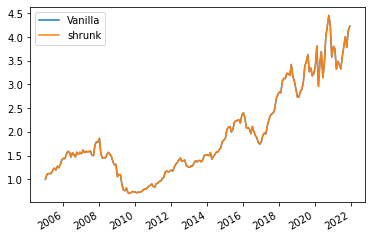

In [29]:
(pd.concat([port_returns,port_shrunk_returns],axis=1)+1).cumprod().plot()

In [ ]:
#question: update clusters at each rebalance?
#need to fix. my algorithm assumes a solution is feasible, need a better system for choosing thresholds
